In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sess = SparkSession \
    .builder \
    .appName("Data wrangling PySpark SQL example") \
    .getOrCreate()

In [36]:
sess

In [3]:
user_logs = sess.read.json("sparkify_log_small.json")

In [4]:
user_logs.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [5]:
user_logs.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [6]:
user_logs.describe("sessionID").show()

+-------+------------------+
|summary|         sessionID|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [7]:
user_logs.count()

10000

In [15]:
user_logs.select("page")\
    .dropDuplicates()\
    .sort("page")\
    .show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [19]:
user_logs.select("userId", "firstname", "page", "song") \
    .where(user_logs.userId == "1046") \
    .collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

# Calculating Statistics by Hour

In [22]:
user_logs.select("ts").show(5)

+-------------+
|           ts|
+-------------+
|1513720872284|
|1513720878284|
|1513720881284|
|1513720905284|
|1513720913284|
+-------------+
only showing top 5 rows



In [20]:
# udf -> user defined function
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [24]:
user_logs = user_logs.withColumn("hour", get_hour(user_logs.ts))

In [27]:
user_logs.select("ts", "hour").show(5)

+-------------+----+
|           ts|hour|
+-------------+----+
|1513720872284|  22|
|1513720878284|  22|
|1513720881284|  22|
|1513720905284|  22|
|1513720913284|  22|
+-------------+----+
only showing top 5 rows



In [34]:
# check out how number of songs played varies depending on time of day
songs_in_hour = user_logs \
    .filter(user_logs.page=="NextSong") \
    .groupby(user_logs.hour) \
    .count() \
    .orderBy(user_logs.hour.cast("float")) # remember that hour is a string

In [35]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  456|
|   1|  454|
|   2|  382|
|   3|  302|
|   4|  352|
|   5|  276|
|   6|  348|
|   7|  358|
|   8|  375|
|   9|  249|
|  10|  216|
|  11|  228|
|  12|  251|
|  13|  339|
|  14|  462|
|  15|  479|
|  16|  484|
|  17|  430|
|  18|  362|
|  19|  295|
+----+-----+
only showing top 20 rows



In [41]:
songs_in_hour

DataFrame[hour: string, count: bigint]

In [42]:
songs_in_hour_pd = songs_in_hour.toPandas()
# convert hour from Object to numeric type, i.e. int64
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

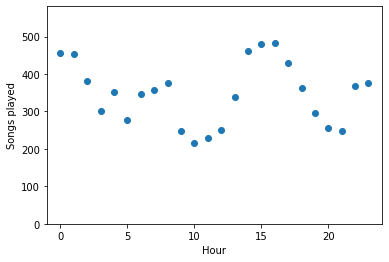

In [48]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.show()

# Drop Rows with Missing Values

It turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [62]:
user_logs_valid = user_logs.dropna(subset=["userId", "sessionId"])

In [63]:
user_logs_valid.count()

10000

In [64]:
user_logs_valid.filter(user_logs_valid.userId == "").count()

336

In [65]:
user_logs_valid = user_logs_valid.filter(user_logs_valid.userId != "")

In [66]:
user_logs_valid.count()

9664

# Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [68]:
user_logs_valid.filter("page == 'Submit Downgrade'").count()

1

In [69]:
user_logs_valid.filter(user_logs_valid.page == "Submit Downgrade").count()

1

In [72]:
user_logs.select(["userId", "firstname", "page", "level", "song"]).where(user_logs.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [80]:
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

In [84]:
user_logs_valid = user_logs_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [86]:
user_logs_valid \
    .select(["userId", "firstname", "page", "level", "song", "downgraded"]) \
    .where(user_logs_valid.userId == "1138") \
    .collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None, downgraded=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody', downgraded=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears', downgraded=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody', downgraded=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)', downgraded=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe', downgraded=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady', downgraded=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel", downgraded=0),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives', downgra

In [87]:
from pyspark.sql import Window

In [88]:
# partitionBy is the same as groupBy
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [89]:
user_logs_valid = user_logs_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [92]:
user_logs_valid \
    .select(["userId", "firstname", "ts", "page", "level", "phase"]) \
    .where(user_logs_valid.userId == "1138") \
    .sort("ts") \
    .collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs